In [1]:
# ============================================
# 1. Imports
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)


# ============================================
# 2. Load & Combine CSV Files
# ============================================
paths = [
    "api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv",
]

dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (2071700, 6)


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [5]:
# ============================================
# 3. Basic Structure & Data Quality
# ============================================
print("\n--- Data Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isna().sum())

print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB
None

--- Missing Values ---
date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
dtype: int64

--- Duplicate Rows ---
473601


In [6]:
# 4. Feature Engineering
# ============================================
df["demo_total"] = df["demo_age_5_17"] + df["demo_age_17_"]

In [7]:
# ============================================
# 5. State Cleaning (Consistency)
# ============================================
def clean_state(state):
    state = str(state).upper()
    state = state.replace("&", "AND")
    state = re.sub(r"[^A-Z ]", "", state)
    state = re.sub(r"\s+", " ", state)
    state = re.sub(r"^THE\s+", "", state)
    return state.strip()

df = df.copy()
df["state"] = df["state"].apply(clean_state)

# Fix known variants
state_fix_map = {
    "WESTBENGAL": "WEST BENGAL",
    "WEST BANGAL": "WEST BENGAL",
    "WEST BENGAL": "WEST BENGAL",
}

df["state"] = df["state"].replace(state_fix_map)

In [24]:
df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_,demo_total,demo_velocity,demo_zscore
2007370,2025-12-20,,100000,100000,0,1,1,0.00,-0.16
795161,2025-12-23,,100000,100000,0,1,1,0.00,-0.16
830786,2025-03-01,DELHI,New Delhi,110001,74,437,511,0.00,3.53
1658258,2025-03-01,DELHI,New Delhi,110001,74,437,511,0.00,3.53
1661868,2025-06-01,DELHI,New Delhi,110001,44,321,365,-146.00,2.47


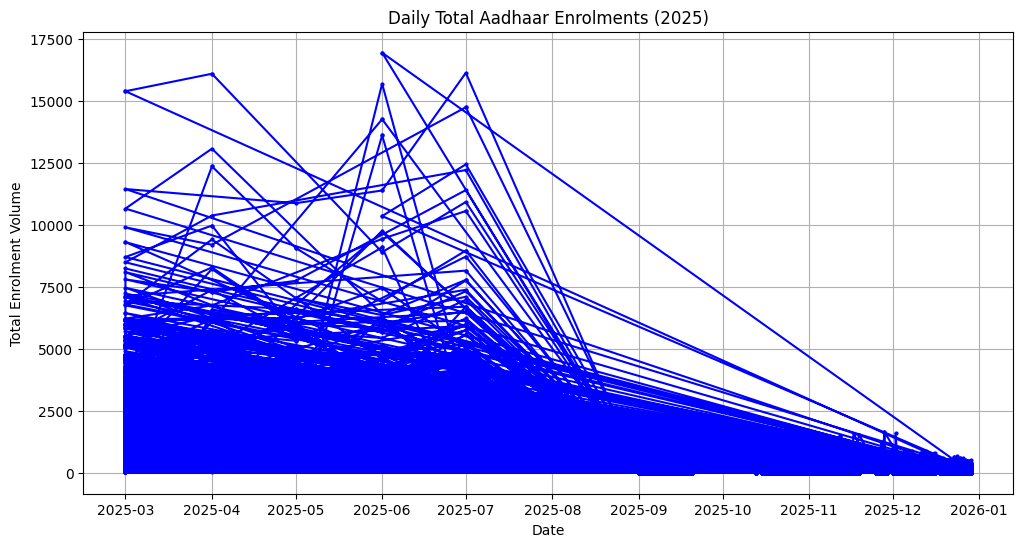

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['demo_total'], marker='o', color='b', markersize=2)
plt.title('Daily Total Aadhaar Enrolments (2025)')
plt.xlabel('Date')
plt.ylabel('Total Enrolment Volume')
plt.grid(True)
plt.savefig('temporal_trends.png')

In [26]:
df_copy = df

In [28]:
import seaborn as sns

/var/folders/zv/n_w2gt8n32l8wmwk5lylj1b40000gn/T/ipykernel_98892/4087625684.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_df.head(15), x='demo_total', y='state', palette='magma')


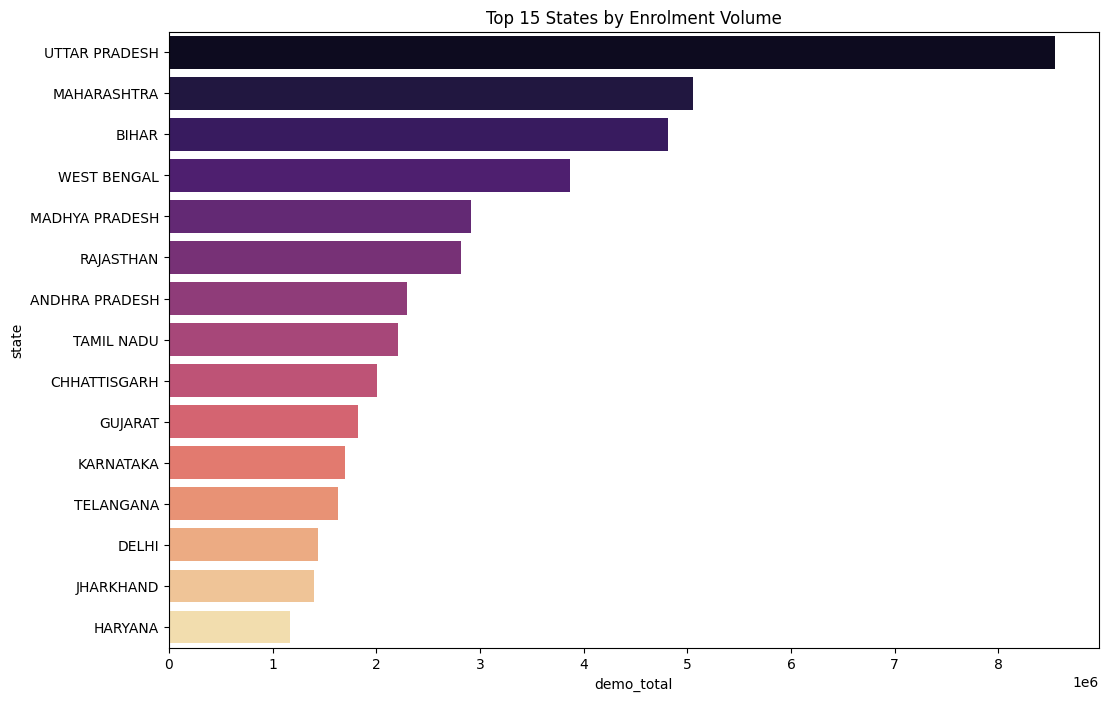

In [29]:
# B. State-wise Distribution: Identify high-activity regions
state_df = df_copy.groupby('state')['demo_total'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=state_df.head(15), x='demo_total', y='state', palette='magma')
plt.title('Top 15 States by Enrolment Volume')
plt.savefig('state_distribution.png')


--- Numerical Summary ---
       demo_age_5_17  demo_age_17_  demo_total
count     2071700.00    2071700.00  2071700.00
mean            2.35         21.45       23.79
std            14.90        125.25      138.20
min             0.00          0.00        0.00
25%             0.00          2.00        3.00
50%             1.00          6.00        7.00
75%             2.00         15.00       17.00
max          2690.00      16166.00    16942.00


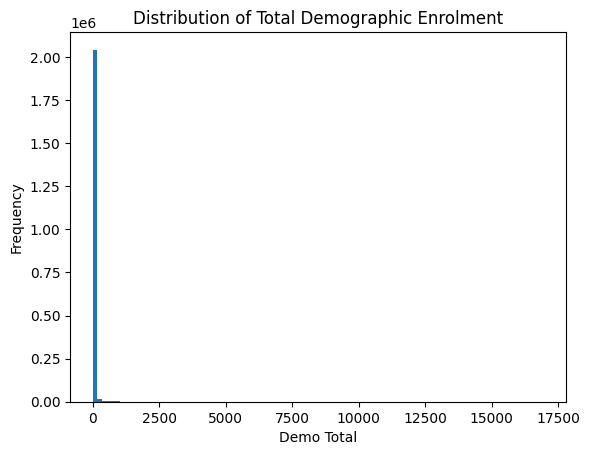

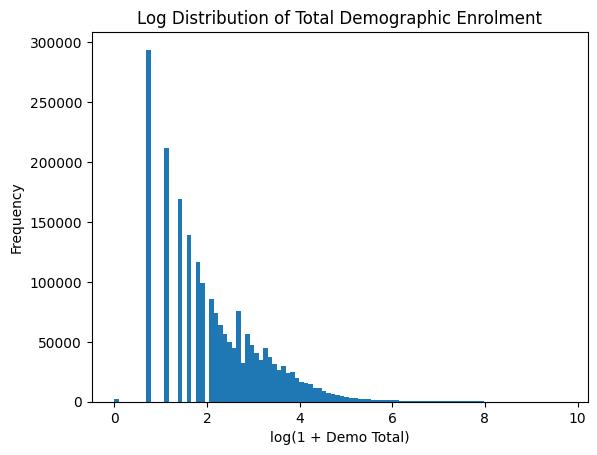

In [8]:
# 6. Descriptive Statistics
# ============================================
print("\n--- Numerical Summary ---")
print(df[["demo_age_5_17", "demo_age_17_", "demo_total"]].describe())


# ============================================
# 7. Distribution Analysis
# ============================================
plt.figure()
plt.hist(df["demo_total"], bins=100)
plt.title("Distribution of Total Demographic Enrolment")
plt.xlabel("Demo Total")
plt.ylabel("Frequency")
plt.show()

# Log-scale distribution
plt.figure()
plt.hist(np.log1p(df["demo_total"]), bins=100)
plt.title("Log Distribution of Total Demographic Enrolment")
plt.xlabel("log(1 + Demo Total)")
plt.ylabel("Frequency")
plt.show()

In [9]:
# ============================================
# 8. Zero & Extreme Values
# ============================================
print("\n--- Zero Enrolment Rows ---")
print((df["demo_total"] == 0).sum())

print("\n--- Top 1% Threshold ---")
print(df["demo_total"].quantile(0.99))


--- Zero Enrolment Rows ---
2139

--- Top 1% Threshold ---
246.0


In [10]:
# ============================================
# 9. State-wise Aggregation
# ============================================
state_demo = (
    df.groupby("state", as_index=False)["demo_total"]
      .sum()
      .sort_values("demo_total", ascending=False)
)

print("\n--- State-wise Demographic Enrolment (Top 15) ---")
print(state_demo.head(15))


--- State-wise Demographic Enrolment (Top 15) ---
             state  demo_total
46   UTTAR PRADESH     8542328
28     MAHARASHTRA     5054602
6            BIHAR     4814350
49     WEST BENGAL     3872734
27  MADHYA PRADESH     2912938
41       RAJASTHAN     2817615
2   ANDHRA PRADESH     2295582
43      TAMIL NADU     2212228
9     CHHATTISGARH     2005434
16         GUJARAT     1824327
22       KARNATAKA     1695285
44       TELANGANA     1629908
14           DELHI     1438934
21       JHARKHAND     1401189
17         HARYANA     1166140


In [11]:
# ============================================
# 10. District-wise Aggregation (Top 20)
# ============================================
district_demo = (
    df.groupby(["state", "district"], as_index=False)["demo_total"]
      .sum()
      .sort_values("demo_total", ascending=False)
)

print("\n--- District-wise Demographic Enrolment (Top 20) ---")
print(district_demo.head(20))


--- District-wise Demographic Enrolment (Top 20) ---
              state           district  demo_total
550     MAHARASHTRA              Thane      447253
541     MAHARASHTRA               Pune      438478
1034    WEST BENGAL  South 24 Parganas      401176
1019    WEST BENGAL        Murshidabad      371953
264         GUJARAT              Surat      357582
221           DELHI   North West Delhi      313989
377       KARNATAKA          Bengaluru      303924
1023    WEST BENGAL  North 24 Parganas      290477
752       RAJASTHAN             Jaipur      275340
1040    WEST BENGAL     Uttar Dinajpur      270232
233         GUJARAT          Ahmedabad      267884
549     MAHARASHTRA            Solapur      265546
128           BIHAR     East Champaran      248028
537     MAHARASHTRA             Nashik      246100
146           BIHAR              Patna      243772
898   UTTAR PRADESH           Bareilly      241742
917   UTTAR PRADESH          Ghaziabad      239761
534     MAHARASHTRA         

In [12]:
# ============================================
# 11. Pincode Concentration Check
# ============================================
print("\n--- Pincode Record Count ---")
print(df["pincode"].value_counts().describe())


--- Pincode Record Count ---
count   19742.00
mean      104.94
std        50.11
min         1.00
25%        80.00
50%        90.00
75%       123.00
max       488.00
Name: count, dtype: float64


In [16]:
# ============================================
# 12. Velocity Preparation (Time-Series Ready)
# ============================================
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["pincode", "date"])

df["demo_velocity"] = (
    df.groupby("pincode")["demo_total"].diff()
)

df["demo_velocity"] = df["demo_velocity"].fillna(0)

In [14]:
df["date"] = pd.to_datetime(
    df["date"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)


In [15]:
df[df["date"].isna()][["date"]].head()


,date


In [17]:
# ============================================
# 13. Velocity Statistics
# ============================================
print("\n--- Demographic Velocity Summary ---")
print(df["demo_velocity"].describe())


--- Demographic Velocity Summary ---
count   2071700.00
mean         -3.72
std          92.60
min      -16941.00
25%          -3.00
50%           0.00
75%           3.00
max       13948.00
Name: demo_velocity, dtype: float64


In [18]:
# ============================================
# 14. Z-Score (Anomaly Readiness)
# ============================================
df["demo_zscore"] = (
    (df["demo_total"] - df["demo_total"].mean())
    / df["demo_total"].std()
)

print("\n--- Z-Score Summary ---")
print(df["demo_zscore"].describe())


--- Z-Score Summary ---
count   2071700.00
mean         -0.00
std           1.00
min          -0.17
25%          -0.15
50%          -0.12
75%          -0.05
max         122.42
Name: demo_zscore, dtype: float64


In [19]:
# ============================================
# 15. Save Clean EDA Output (Optional)
# ============================================
df.to_csv("cleaned_aadhar_demographic_eda.csv", index=False)
state_demo.to_csv("state_demographic_summary.csv", index=False)